# Multiple output regression of an Energy efficiency dataset
https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx

In [1]:
import tensorflow as tf  # export CUDA_VISIBLE_DEVICES=0,1
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))  # !python3 -c "import tensorflow as tf; physical_devices = tf.config.list_physical_devices('GPU');  print(\"Number of GPUs:\", len(physical_devices))"
from time import perf_counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
# from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import pydot

2025-07-28 01:08:46.103985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753661326.125666 3293396 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753661326.132127 3293396 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753661326.148920 3293396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753661326.148948 3293396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753661326.148950 3293396 computation_placer.cc:177] computation placer alr

Num GPUs: 2


In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / (train_stats['std'])

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True values')
    plt.title('Predictions')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100],[-100, 100])
    plt.show()

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color="blue", label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(URL)
df.sample(frac=1).reset_index(drop=True)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.66,759.5,318.5,220.5,3.5,4,0.40,4,15.09,18.36
1,0.66,759.5,318.5,220.5,3.5,3,0.10,3,11.60,13.70
2,0.79,637.0,343.0,147.0,7.0,3,0.25,5,39.83,36.66
3,0.71,710.5,269.5,220.5,3.5,3,0.25,3,12.28,14.74
4,0.86,588.0,294.0,147.0,7.0,4,0.40,1,32.09,31.70
...,...,...,...,...,...,...,...,...,...,...
763,0.74,686.0,245.0,220.5,3.5,2,0.10,2,10.42,13.39
764,0.66,759.5,318.5,220.5,3.5,3,0.40,4,15.29,17.82
765,0.64,784.0,343.0,220.5,3.5,2,0.25,1,17.50,21.13
766,0.62,808.5,367.5,220.5,3.5,4,0.10,3,12.71,14.14


In [3]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalise the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)


# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])
print(model.summary())

I0000 00:00:1753661331.346762 3293396 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46537 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:09:00.0, compute capability: 8.9
I0000 00:00:1753661331.349164 3293396 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46353 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:42:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,152 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_output (Dense)   │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_output (Dense)   │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


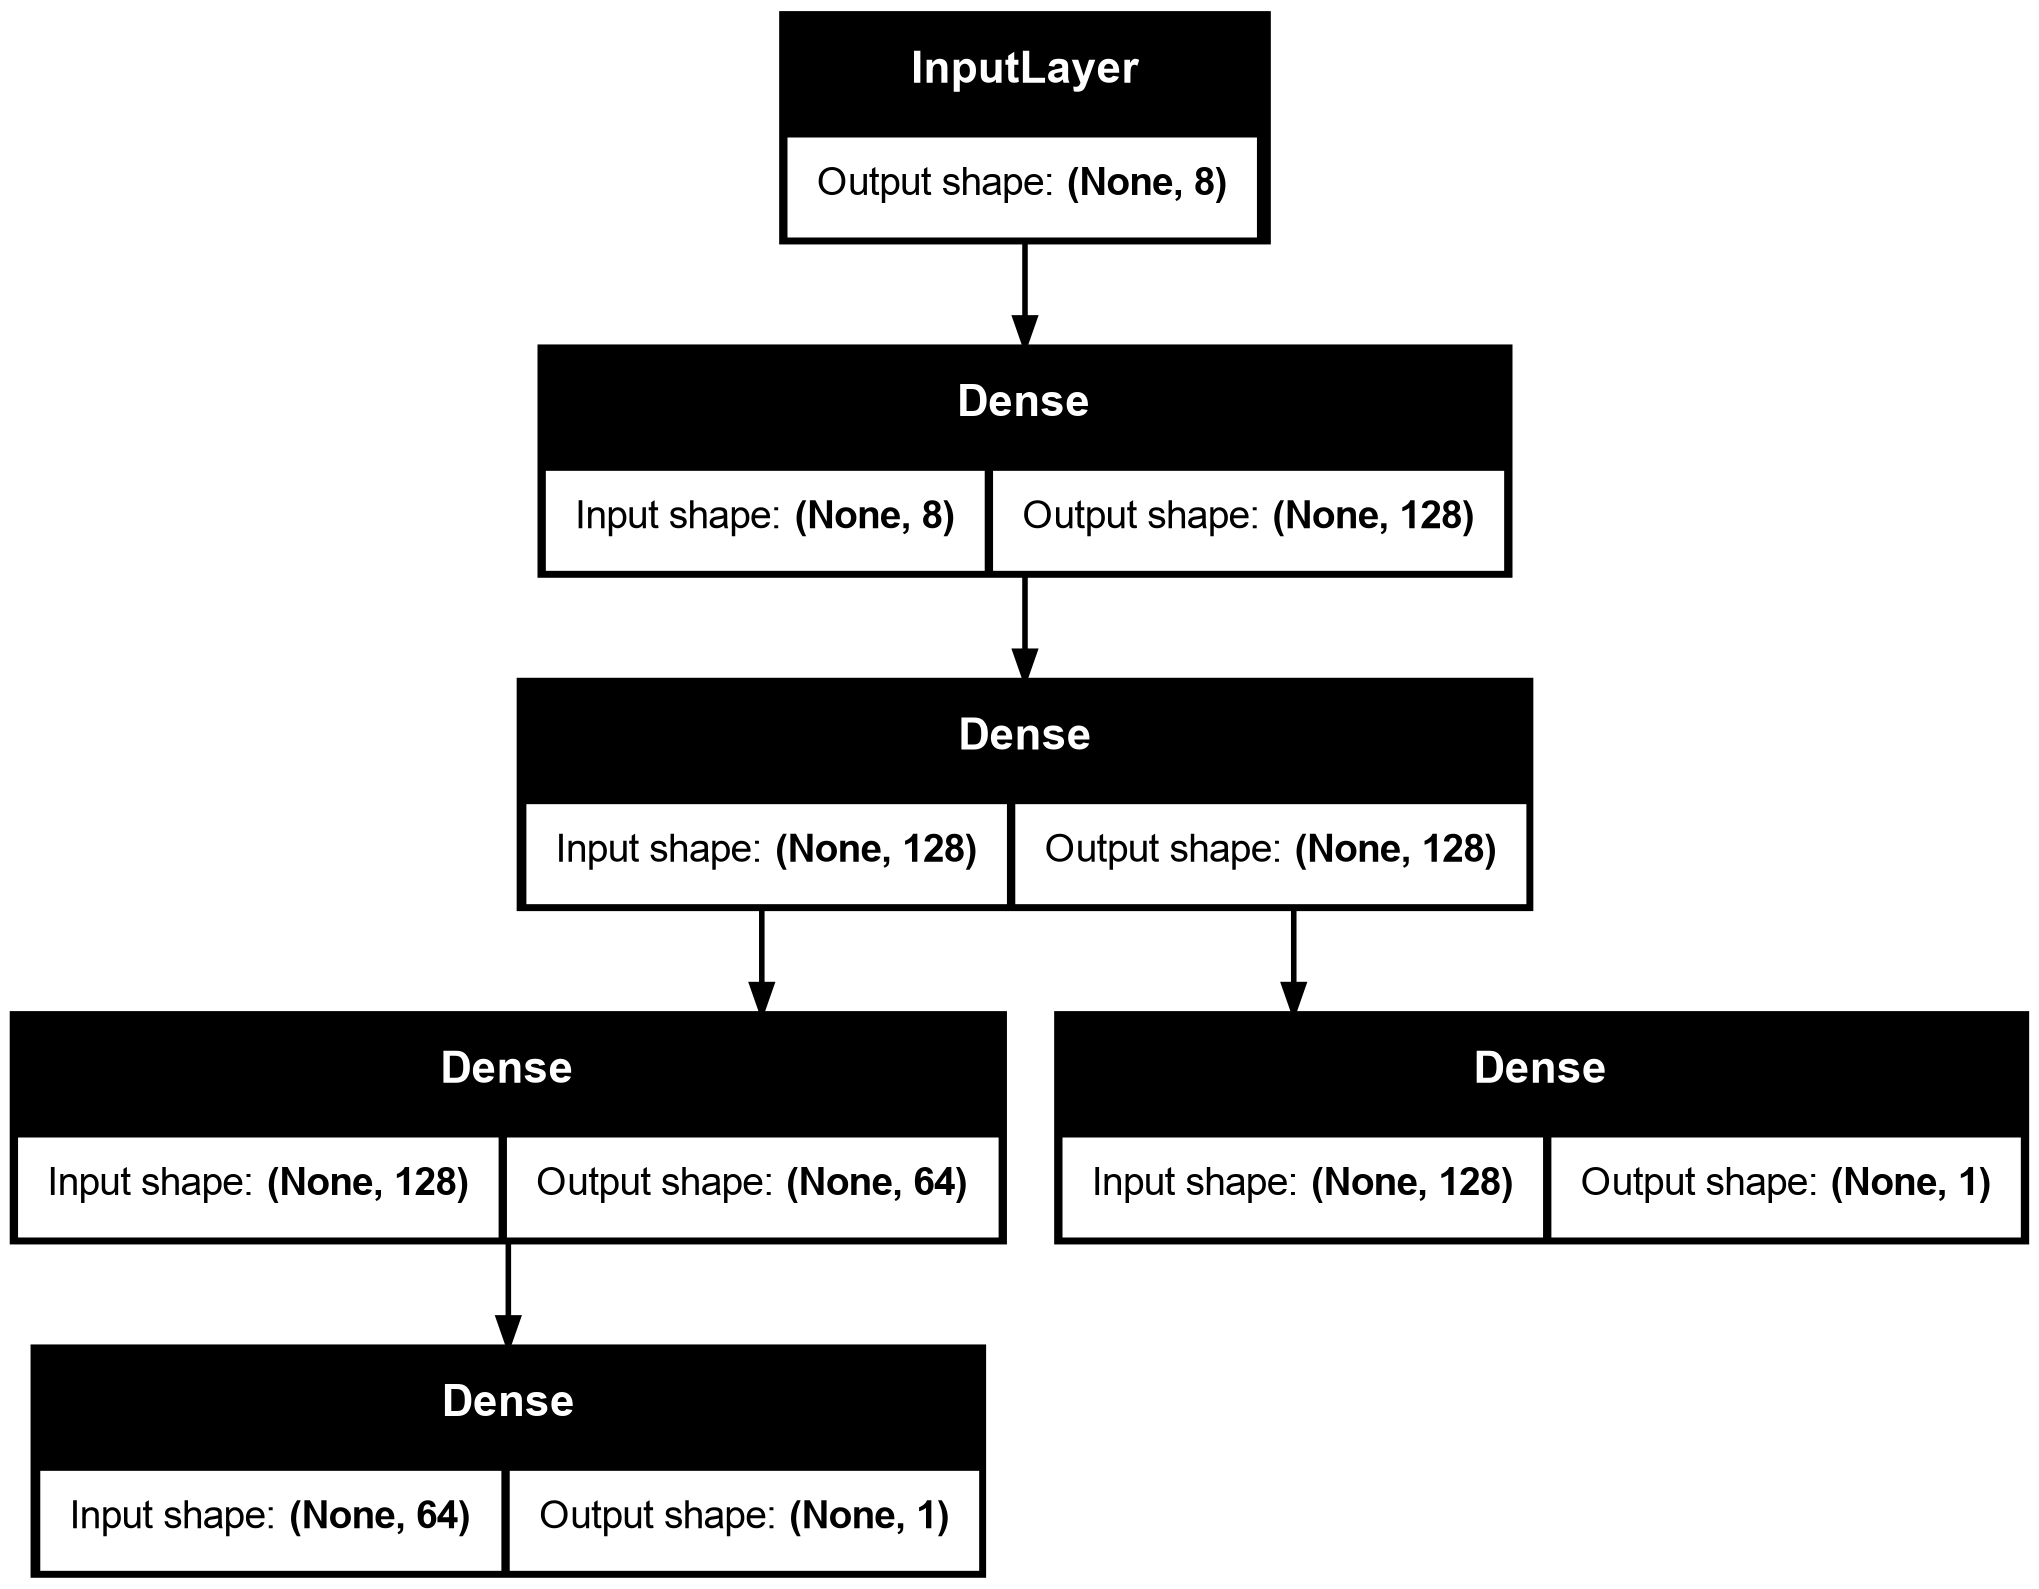

In [4]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

plot_model(model, show_shapes=True, to_file='model.png')

In [5]:
from tensorflow.keras.callbacks import Callback

class EpochLogger(Callback):
    def __init__(self, every=100):
        super().__init__()
        self.every = every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every == 0 or epoch == 0:
            logs = logs or {}
            print(f"Epoch {epoch + 1}: " + ", ".join(f"{k}={v:.4f}" for k, v in logs.items()))

In [6]:
# Train the model for 2000 epochs
start = perf_counter()
history = model.fit(norm_train_X, 
                    train_Y,
                    epochs=2000, 
                    batch_size=10, 
                    validation_data=(norm_test_X, test_Y),
                    verbose=0, 
                    callbacks=[EpochLogger(every=100)]
                   )
end = perf_counter()
print(f"Elapsed time: {elapsed / 60:.2f} minutes")

I0000 00:00:1753661333.745245 3293588 service.cc:152] XLA service 0x748754007740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753661333.745279 3293588 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1753661333.745285 3293588 service.cc:160]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-07-28 01:08:53.767976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753661333.857254 3293588 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753661336.219093 3293588 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: loss=277.0004, val_loss=59.9357, val_y1_output_loss=24.9713, val_y1_output_root_mean_squared_error=4.8956, val_y2_output_loss=36.5631, val_y2_output_root_mean_squared_error=5.9974, y1_output_loss=129.7126, y1_output_root_mean_squared_error=11.4418, y2_output_loss=144.7617, y2_output_root_mean_squared_error=12.0866
Epoch 100: loss=2.7204, val_loss=4.3582, val_y1_output_loss=0.7885, val_y1_output_root_mean_squared_error=0.8711, val_y2_output_loss=3.6997, val_y2_output_root_mean_squared_error=1.8972, y1_output_loss=0.7015, y1_output_root_mean_squared_error=0.8403, y2_output_loss=2.0318, y2_output_root_mean_squared_error=1.4192
Epoch 200: loss=0.8285, val_loss=3.9809, val_y1_output_loss=0.5310, val_y1_output_root_mean_squared_error=0.7191, val_y2_output_loss=3.5528, val_y2_output_root_mean_squared_error=1.8612, y1_output_loss=0.1879, y1_output_root_mean_squared_error=0.4315, y2_output_loss=0.6446, y2_output_root_mean_squared_error=0.8014
Epoch 300: loss=1.7129, val_loss=1.8991, va

2025-07-28 01:18:36.209129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads

2025-07-28 01:18:36.219557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 12 bytes spill stores, 12 bytes spill loads

2025-07-28 01:18:36.249937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 12 bytes spill stores, 12 bytes spill loads



1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.3512 - y1_output_loss: 0.1250 - y1_output_root_mean_squared_error: 0.3535 - y2_output_loss: 0.2262 - y2_output_root_mean_squared_error: 0.4757

2025-07-28 01:18:37.707770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 12 bytes spill stores, 12 bytes spill loads

2025-07-28 01:18:37.755209: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 12 bytes spill stores, 12 bytes spill loads

2025-07-28 01:18:37.817463: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 0.4251 - y1_output_loss: 0.1130 - y1_output_root_mean_squared_error: 0.3358 - y2_output_loss: 0.3122 - y2_output_root_mean_squared_error: 0.5573
Loss = 0.43379923701286316, Y1_loss = 0.11242437362670898, Y1_mse = 0.33491456508636475, Y2_loss = 0.32177338004112244, Y2_mse = 0.5671255588531494
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


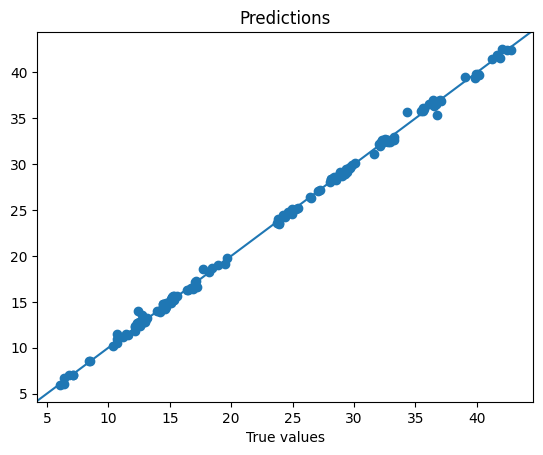

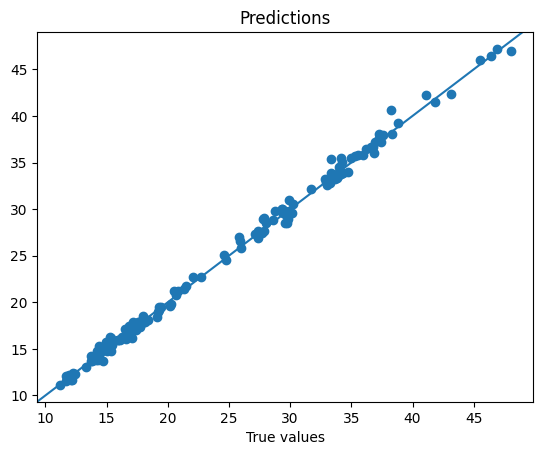

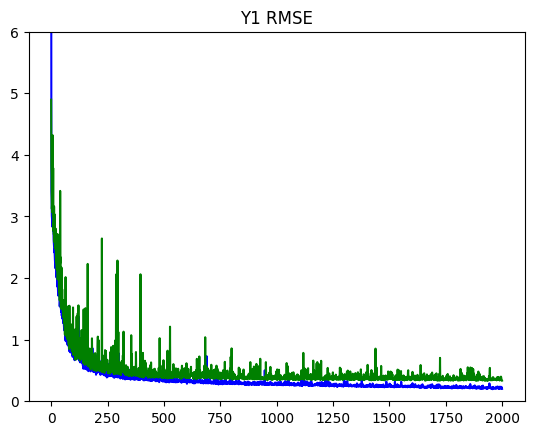

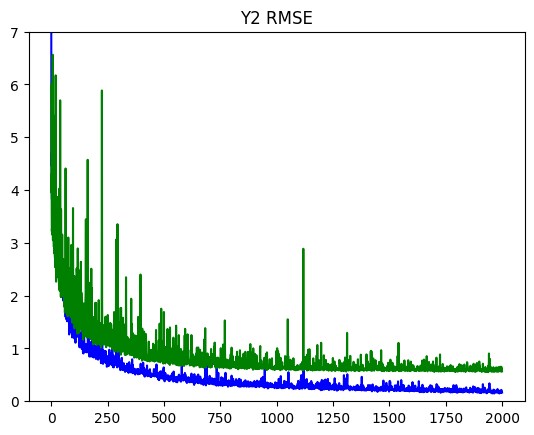

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(
    loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')

plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)